In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder, CatBoostEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
train = pd.read_csv(r'../input/playground-series-s3e19/train.csv')
test_1 = pd.read_csv(r'../input/playground-series-s3e19/test.csv')

train.drop('id', axis = 1, inplace = True)
test = test_1.drop('id', axis = 1)

In [6]:
train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [7]:
desc = pd.DataFrame(index = list(train))
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['type'] = train.dtypes
desc = pd.concat([desc, train.describe().T.drop('count', axis = 1)], axis = 1)
desc

,count,nunique,%unique,null,type,mean,std,min,25%,50%,75%,max
date,136950,1826,1.333333,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,136950,5,0.003651,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store,136950,3,0.002191,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product,136950,5,0.003651,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_sold,136950,1028,0.750639,0,int64,165.522636,183.691575,2.0,46.0,98.0,184.0,1380.0


In [8]:
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')
test.date = pd.to_datetime(test.date, format = '%Y-%m-%d')

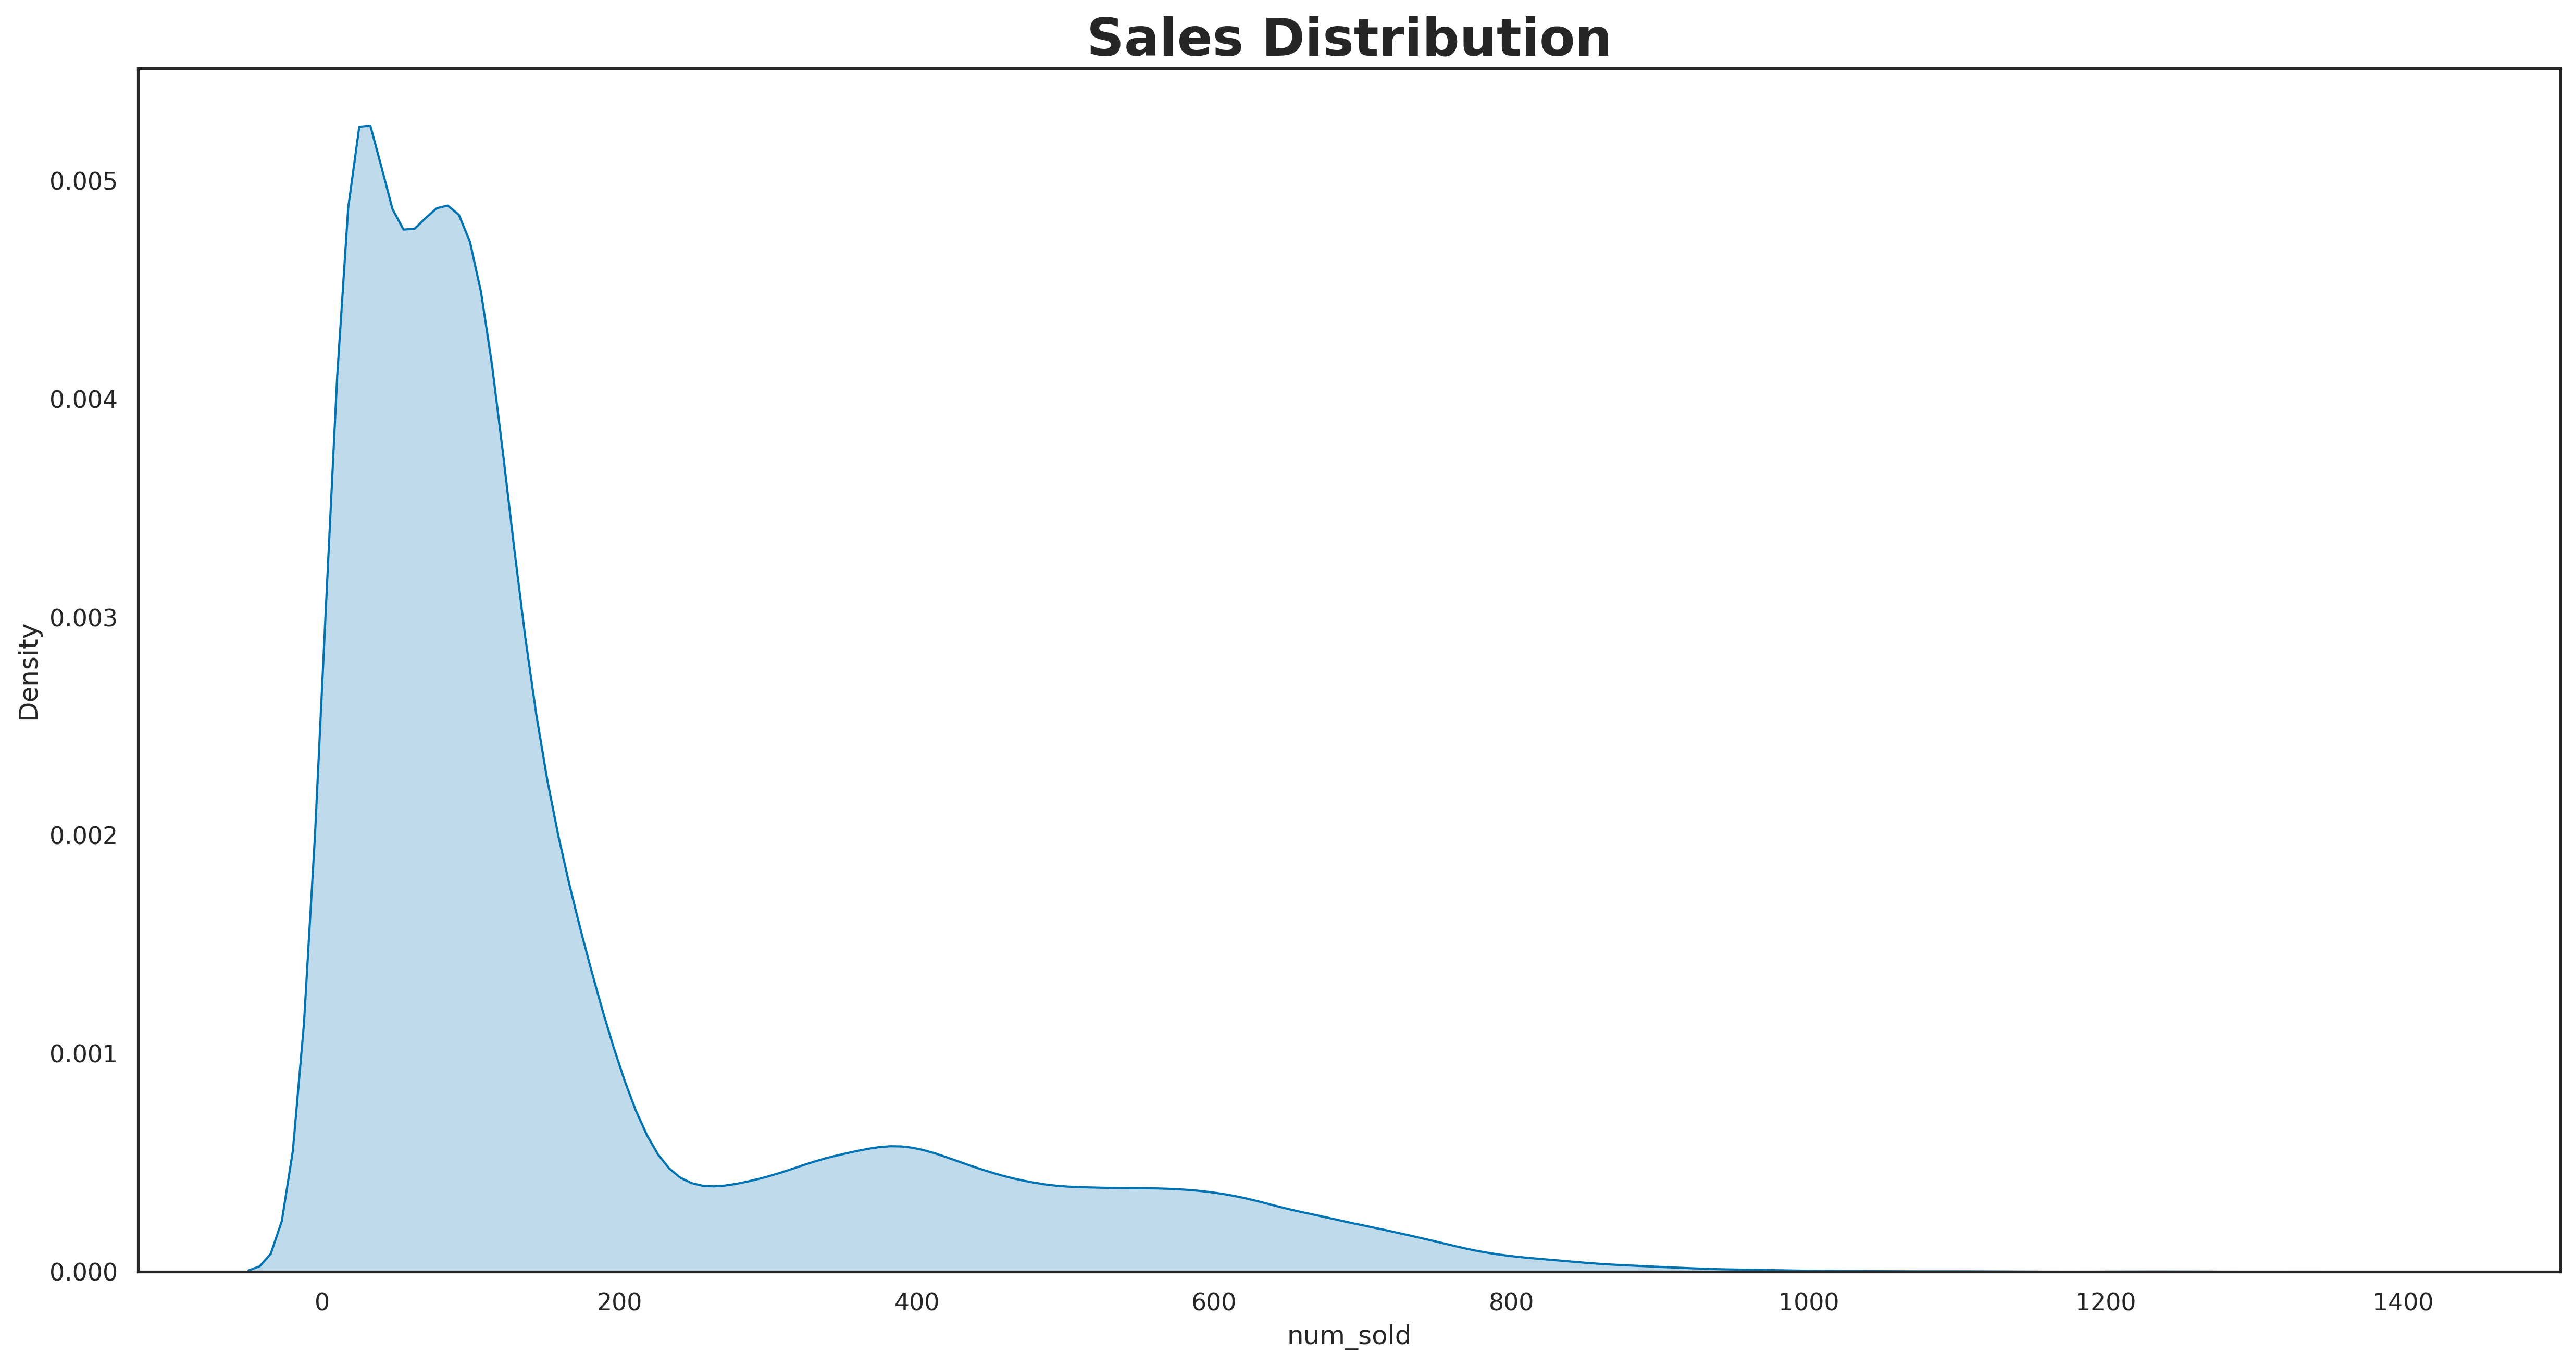

In [9]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.kdeplot(data = train, x = 'num_sold', fill = True)
    
plt.title('Sales Distribution', fontsize = 24, fontweight = 'bold')
plt.show()

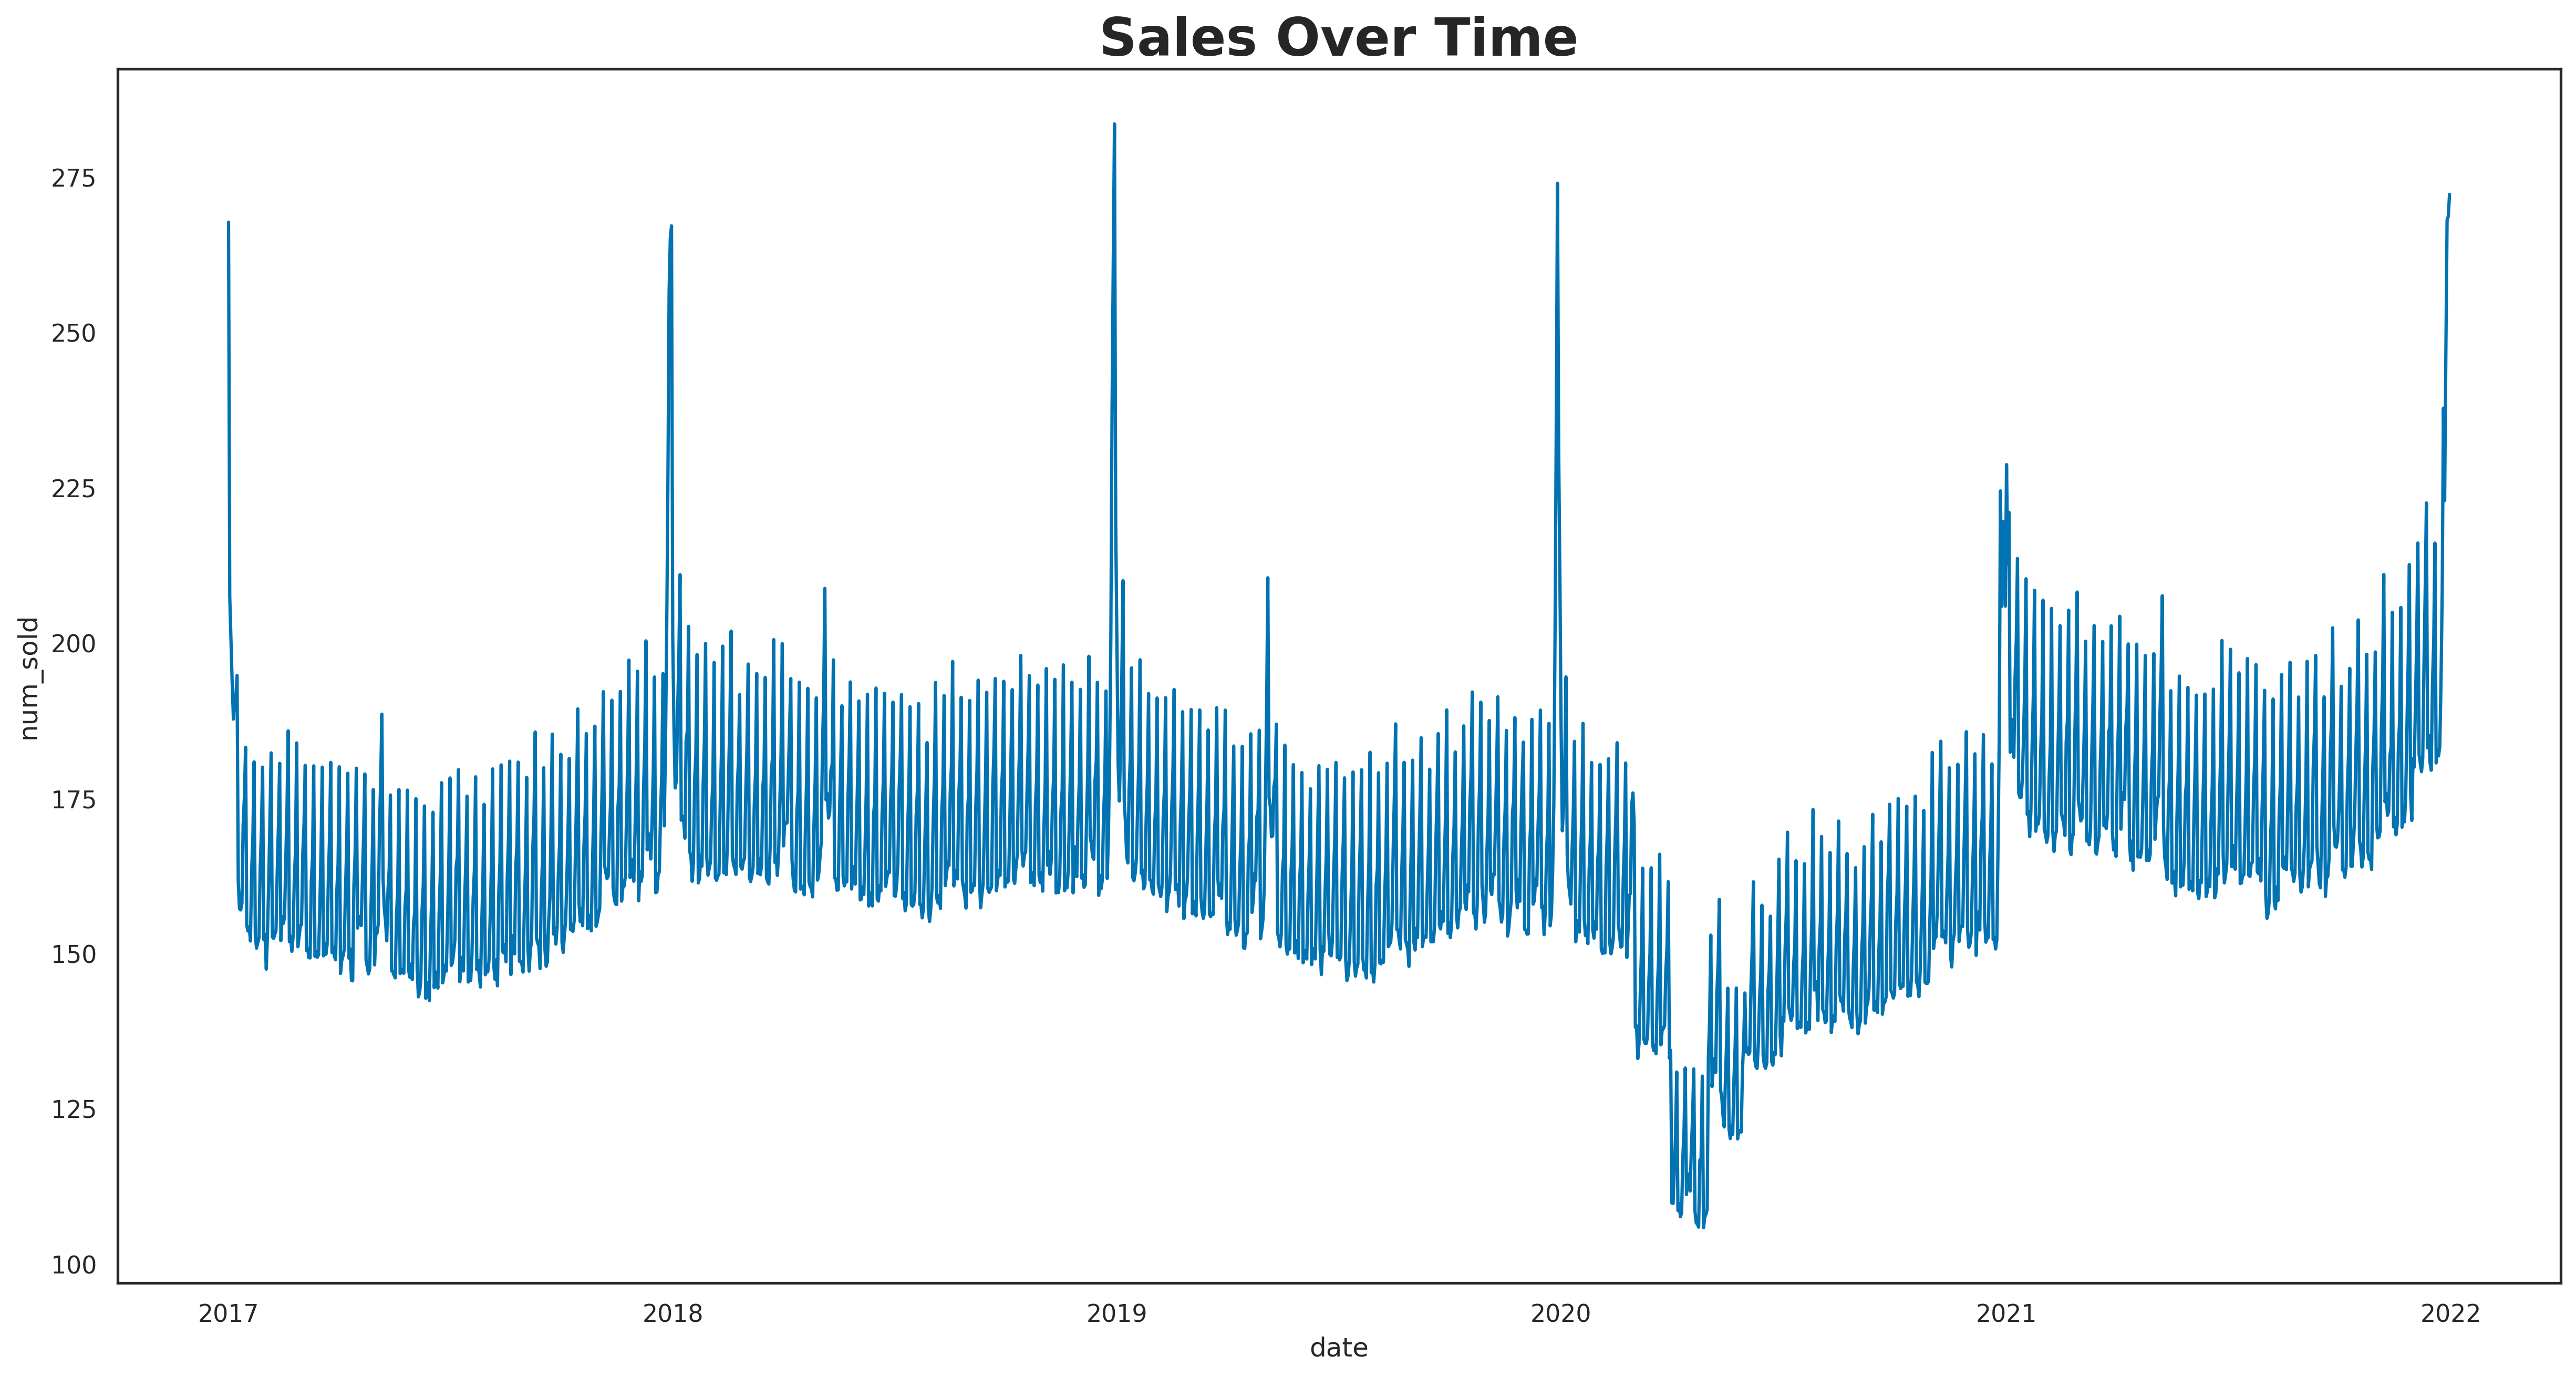

In [10]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'date', y = 'num_sold', errorbar = None)
    
plt.title('Sales Over Time', fontsize = 24, fontweight = 'bold')
plt.show()

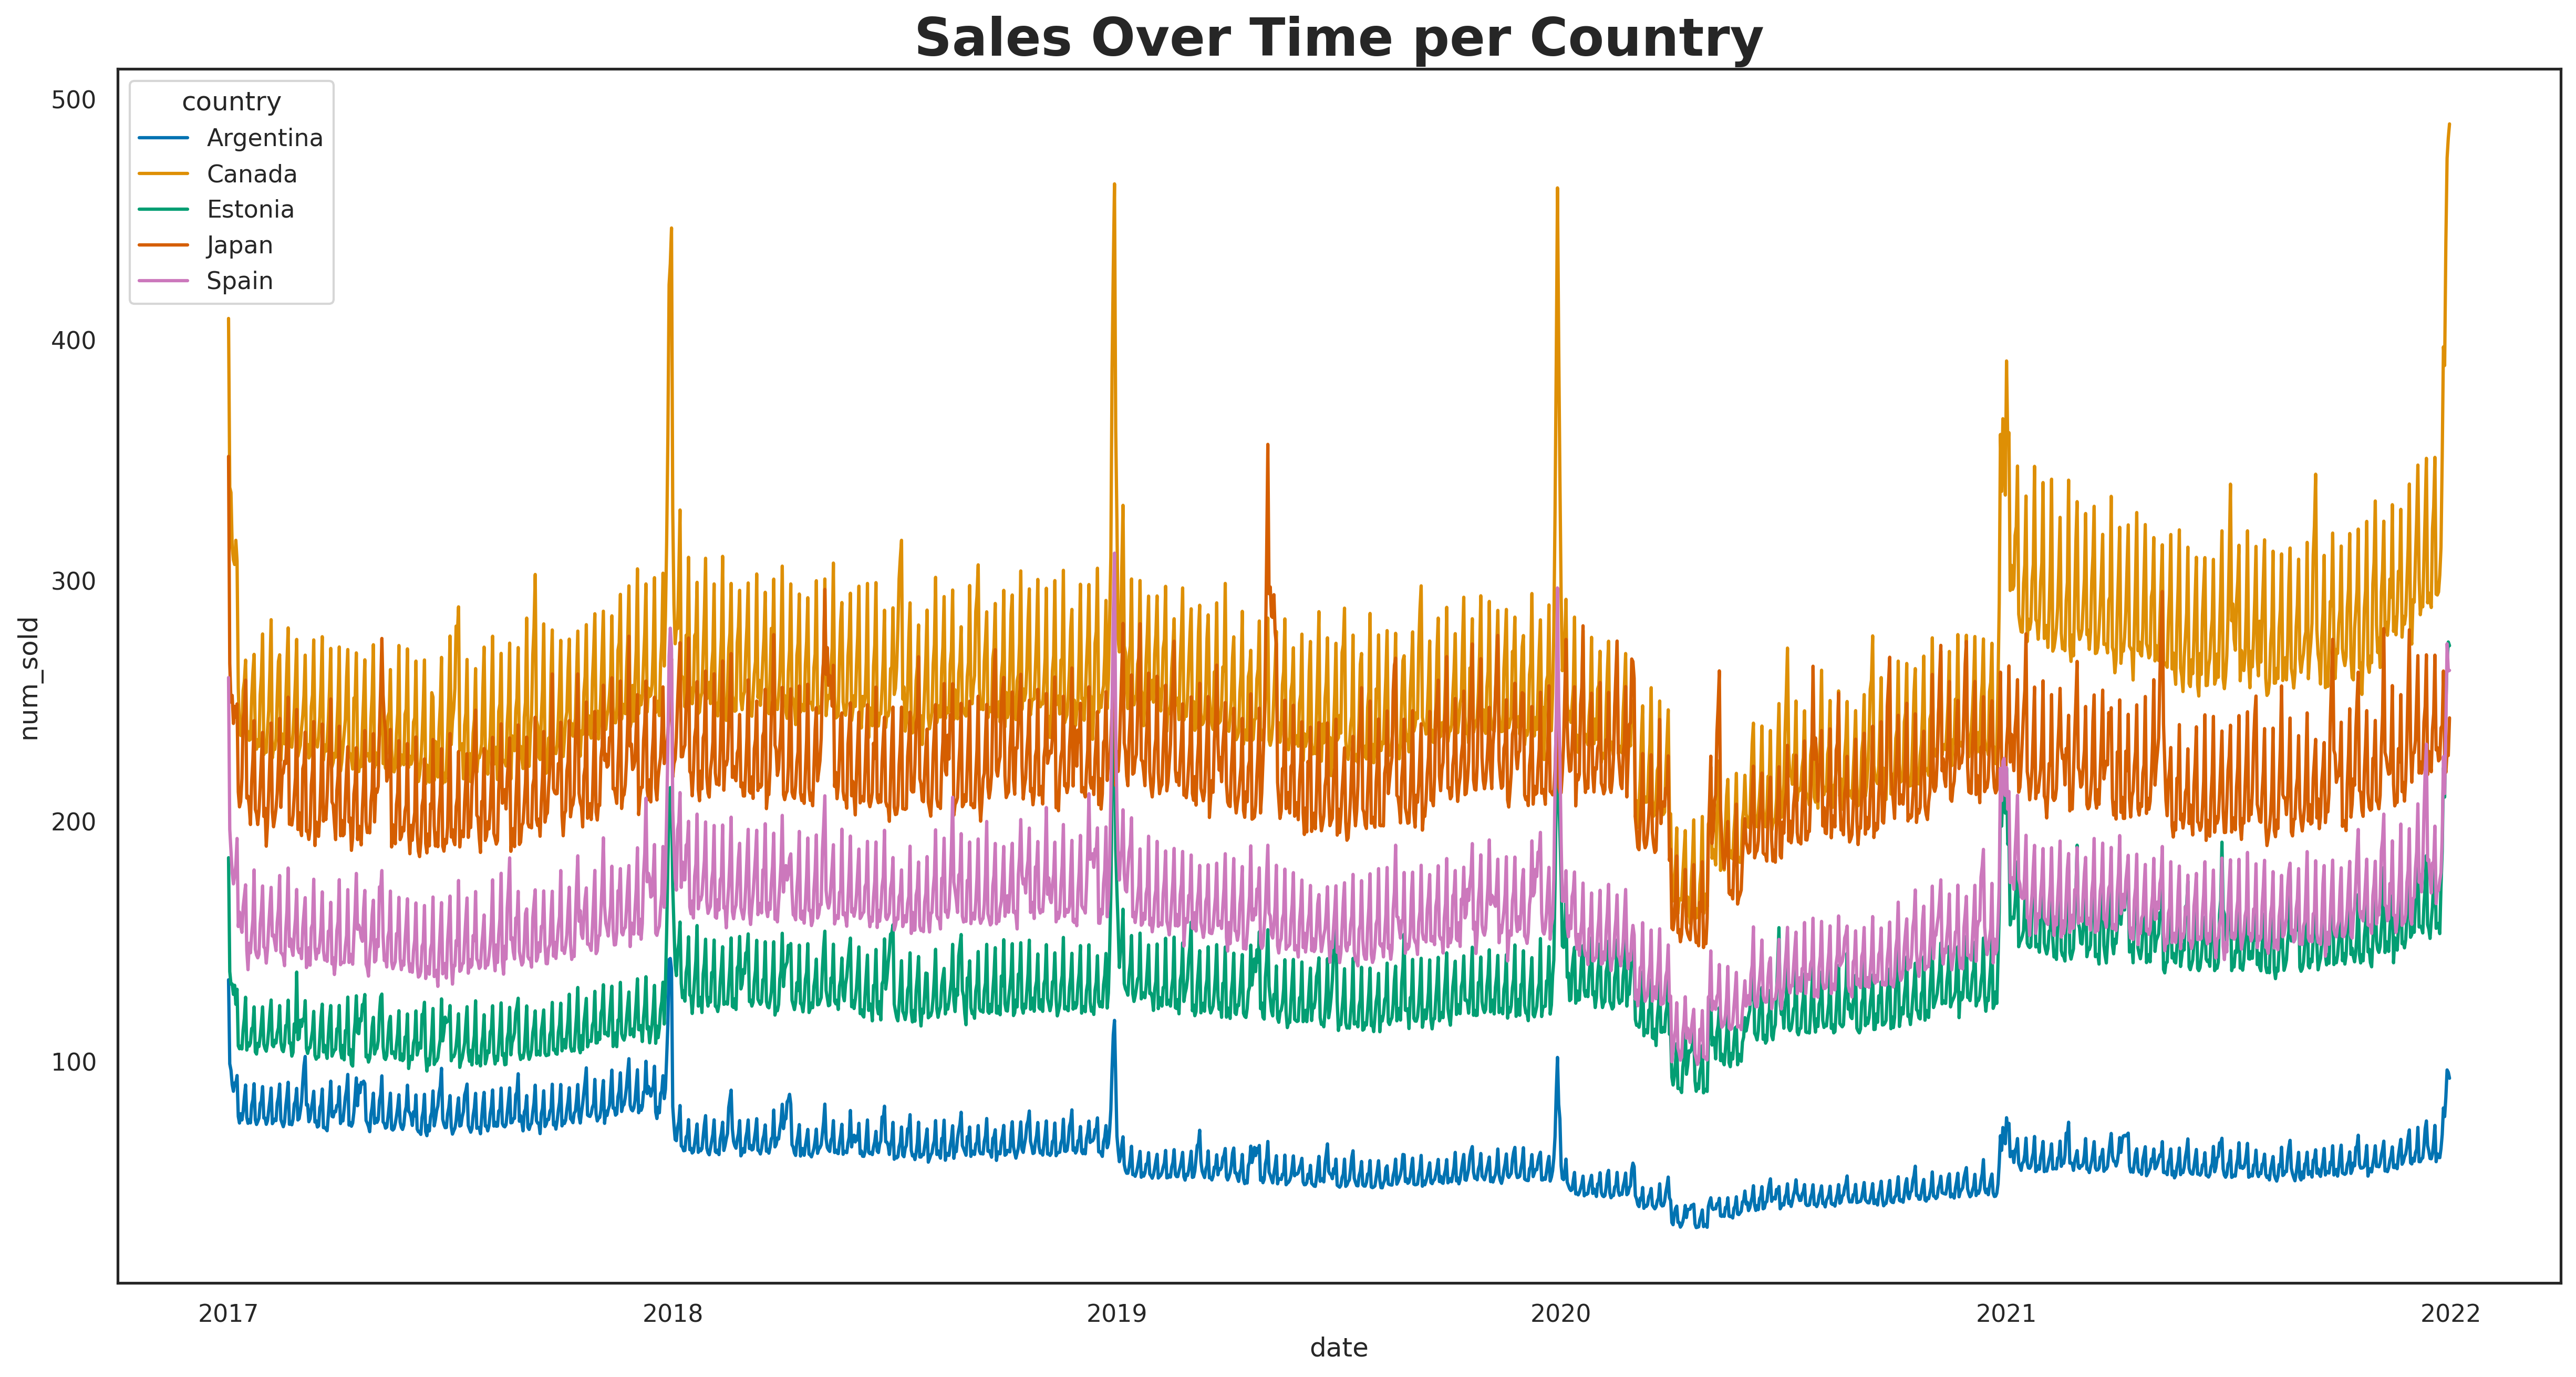

In [11]:

plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'date', y = 'num_sold', hue = 'country', errorbar = None)
    
plt.title('Sales Over Time per Country', fontsize = 24, fontweight = 'bold')
plt.show()

In [12]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [13]:
X = train.copy()
y = X.pop('num_sold')
y = np.log1p(y)

seed = 42
k = TimeSeriesSplit(n_splits = 4, test_size = 27390)

np.random.seed(seed)

In [14]:
class DateProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, x, y = None): 
        return self
    def transform(self, x, y = None):
        x_copy = x.copy()
        x_copy['day'] = x_copy.date.dt.day
        x_copy['month'] = x_copy.date.dt.month
        x_copy['year'] = x_copy.date.dt.year
        x_copy['dow'] = x_copy.date.dt.dayofweek
        x_copy = x_copy.drop('date', axis = 1)
        return x_copy   

In [15]:
def multipliers(predictors, prediction, canada = 1, japan = 1, spain = 1, estonia = 1, argentina = 1):
    prediction[predictors.country == 'Canada'] *= canada
    prediction[predictors.country == 'Japan'] *= japan
    prediction[predictors.country == 'Spain'] *= spain
    prediction[predictors.country == 'Estonia'] *= estonia
    prediction[predictors.country == 'Argentina'] *= argentina
    return prediction

In [17]:
def cross_val_score(model, cv = k, label = ''):
    
    X = train.copy()
    y = X.pop('num_sold')
    y = np.log1p(y)
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(train)))
    #train_predictions = np.zeros((len(train)))
    train_scores, val_scores = [], []
    
    #training model, predicting prognosis probability, and evaluating log loss
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
          #define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        #define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
                  
        val_predictions[val_idx] += val_preds
        
         #reverse log-transformation
        y_train = np.expm1(y_train)
        y_val = np.expm1(y_val)
        
        train_preds = np.expm1(train_preds)
        val_preds = np.expm1(val_preds)
        
        #evaluate model for a fold
        train_score = smape(y_train, train_preds)
        val_score = smape(y_val, val_preds)
        
        #append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
        
        print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    
    return val_scores, val_predictions
        

In [18]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('lgb', LGBMRegressor(random_state = seed, objective = 'mae')),
    ('cb', CatBoostRegressor(random_state = seed, verbose = 0, objective = 'MAE')),
    ('gb', GradientBoostingRegressor(random_state = seed, loss = 'absolute_error')),
    ('hgb', HistGradientBoostingRegressor(random_state = seed, loss = 'absolute_error'))
]

Encoder = GLMMEncoder(cols = ['country', 'store', 'product'], random_state = seed)

In [19]:
for (label, model) in models:
     score_list[label], oof_list[label] = cross_val_score(
         make_pipeline(DateProcessor(), Encoder, model),
         label = label,
     )

Val Score: 12.78067 ± 0.00000 | Train Score: 4.99858 ± 0.00000 | lgb
Val Score: 11.49074 ± 1.28992 | Train Score: 5.19006 ± 0.19148 | lgb
Val Score: 12.31584 ± 1.57189 | Train Score: 5.32388 ± 0.24548 | lgb
Val Score: 14.24514 ± 3.60828 | Train Score: 5.43630 ± 0.28829 | lgb
Val Score: 13.22358 ± 0.00000 | Train Score: 4.34762 ± 0.00000 | cb
Val Score: 11.00971 ± 2.21387 | Train Score: 4.40005 ± 0.05243 | cb
Val Score: 11.49805 ± 1.93505 | Train Score: 4.45583 ± 0.08975 | cb
Val Score: 13.72988 ± 4.21326 | Train Score: 4.50021 ± 0.10932 | cb
Val Score: 14.10913 ± 0.00000 | Train Score: 7.61924 ± 0.00000 | gb
Val Score: 13.34499 ± 0.76414 | Train Score: 8.09171 ± 0.47247 | gb
Val Score: 14.03276 ± 1.15557 | Train Score: 8.23625 ± 0.43658 | gb
Val Score: 15.27002 ± 2.36515 | Train Score: 8.54923 ± 0.66092 | gb
Val Score: 12.83290 ± 0.00000 | Train Score: 5.05277 ± 0.00000 | hgb
Val Score: 11.55183 ± 1.28108 | Train Score: 5.21558 ± 0.16281 | hgb
Val Score: 12.36614 ± 1.55574 | Train Scor

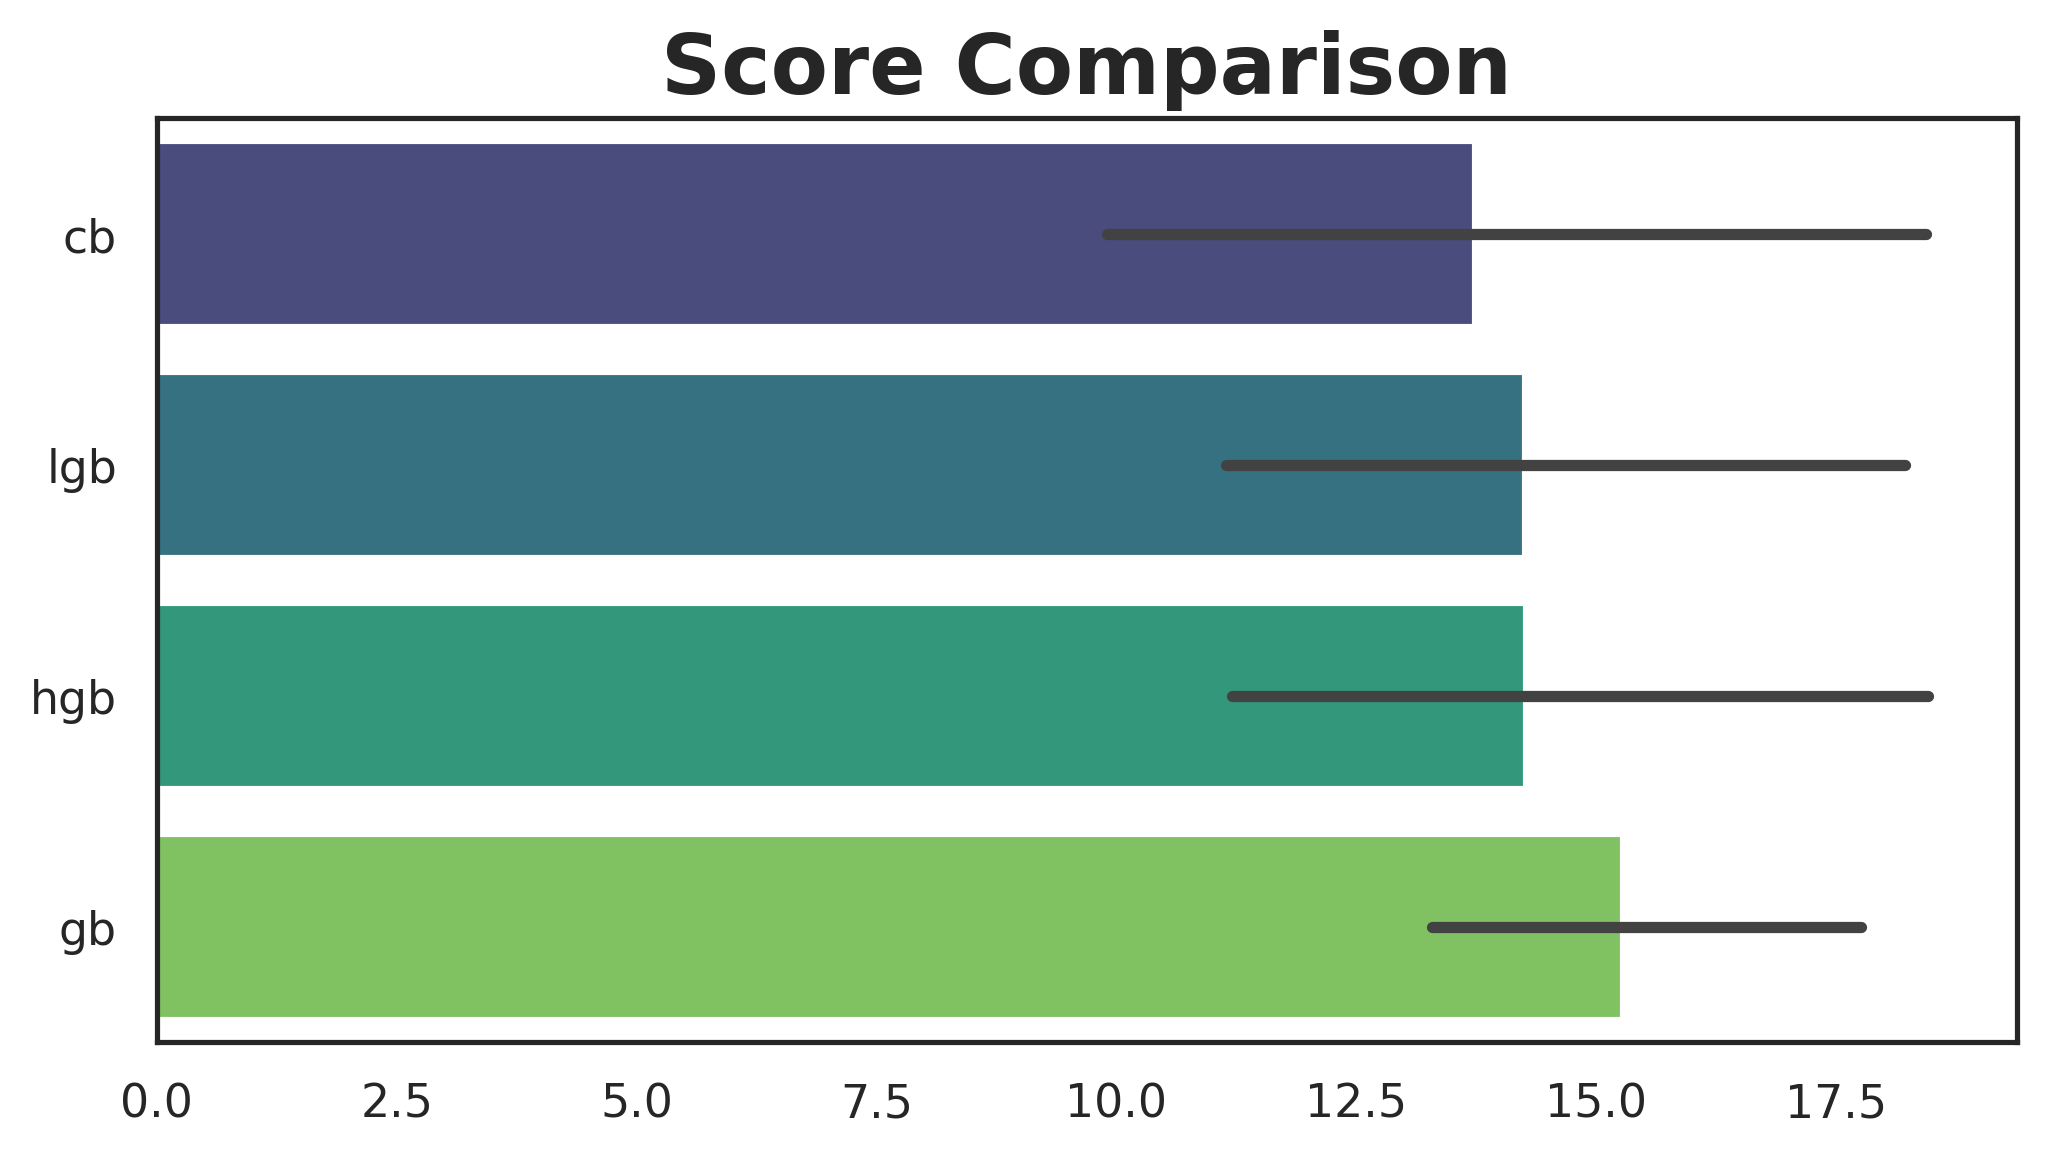

In [20]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()